In [1]:
import ast
from pathlib import Path

import geopandas as gpd
import pandas as pd
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString
from shapely.geometry import Point
from osmnx.distance import great_circle_vec

In [2]:
pd.set_option("display.max_columns", None)
UBASEPATH = Path('/iarai/public/t4c/uber')
UFILE = 'movement-speeds-hourly-london-2019-10.parquet'
# TBASEPATH = Path('/iarai/public/t4c/data_pipeline/release20221003_keep_all_edges_residential_unclassified/2022')

# TBASEPATH = Path('/iarai/public/t4c/data_pipeline/release20221022_historic/2022')

OBASEPATH = Path('/iarai/public/t4c/osm')
place = "england-200101-truncated"
# place = "england-latest-truncated"
ONODESFILE = "%s_nodes.parquet" % place
OWAYSFILE = "%s_ways.parquet" % place

# write_ways_gpkg = True
# write_nodes_gpkg = True

# print(TBASEPATH)

CITY = "london"

uspeeds_df = pd.read_parquet(UBASEPATH / UFILE)
uspeeds_df["osm_way_id"] = uspeeds_df["osm_way_id"].astype(str)
print(uspeeds_df.columns)
# # print(uspeeds_df)
# tedges_df = pd.read_parquet(TBASEPATH / "road_graph" / CITY / "road_graph_freeflow.parquet")
# tnodes_df = pd.read_parquet(TBASEPATH / "road_graph" / CITY / "road_graph_nodes.parquet")
# tedges_df = tedges_df.merge(tnodes_df, how='left', left_on="u", right_on="node_id", suffixes=("", "_u")).merge(
#     tnodes_df, how='left', left_on="v", right_on="node_id", suffixes=("_u", "_v"))

# # explode osmid lists
# tedges_df["osmid_bak"] = tedges_df["osmid"]
# tedges_df["osmid"] = [ast.literal_eval(osmid) for osmid in tedges_df["osmid"]]
# tedges_df = tedges_df.explode("osmid")
# tedges_df["osmid"] = tedges_df["osmid"].astype(str)

# # collapse any highway lists (can happen during graph simplification)
# # into string values simply by keeping just the first element of the list
# tedges_df["highway"] = [ast.literal_eval(highway) if highway.startswith("[") else highway for highway in
#                         tedges_df["highway"]]
# tedges_df["highway"] = tedges_df["highway"].map(lambda x: x[0] if isinstance(x, list) else x)

# print(tedges_df.columns)


uspeeds_df

Index(['osm_start_node_id', 'osm_end_node_id', 'osm_way_id', 'year', 'month',
       'day', 'hour', 'speed_mph_mean', 'speed_mph_stddev'],
      dtype='object')


,osm_start_node_id,osm_end_node_id,osm_way_id,year,month,day,hour,speed_mph_mean,speed_mph_stddev
0,6504105337,1604745704,147247974,2019,10,9,18,18.752,3.781
1,6504105337,1604745704,147247974,2019,10,9,15,19.461,4.255
2,6504105337,1604745704,147247974,2019,10,8,18,13.603,4.862
3,6504105337,1604745704,147247974,2019,10,8,16,15.450,2.076
4,6504105337,1604745704,147247974,2019,10,8,15,17.119,2.450
...,...,...,...,...,...,...,...,...,...
47121785,4804443645,3863127062,688989358,2019,10,21,19,14.349,4.693
47121786,4804443645,3863127062,688989358,2019,10,14,8,12.321,4.213
47121787,4804443645,3863127062,688989358,2019,10,4,8,12.269,4.079
47121788,4804443645,3863127062,688989358,2019,10,7,8,13.596,7.274


In [3]:
#df_nodes_osm = pd.read_parquet(OBASEPATH / ONODESFILE)
df_nodes_osm = gpd.read_parquet(OBASEPATH / ONODESFILE)
print(df_nodes_osm.columns)
# print(df_nodes_osm.dtypes)
# print(df_nodes_osm)

Index(['osmid', 'y', 'x', 'version', 'timestamp', 'changeset', 'geometry'], dtype='object')


In [4]:
#df_ways_osm = pd.read_parquet(OBASEPATH / OWAYSFILE)
df_ways_osm = gpd.read_parquet(OBASEPATH / OWAYSFILE)
df_ways_osm["osmid"] = df_ways_osm["osmid"].astype(str)
df_ways_osm["refs"] = [ast.literal_eval(refs) if refs is not None and refs.startswith("[") else refs for refs in df_ways_osm["refs"]]
print(df_ways_osm.columns)

Index(['osmid', 'version', 'timestamp', 'changeset', 'highway', 'maxspeed',
       'name', 'refs', 'full_geometry', 'valid_geometry', 'geometry'],
      dtype='object')


In [5]:
assert type(df_ways_osm) == gpd.geodataframe.GeoDataFrame

In [6]:
assert uspeeds_df.groupby(
        ["osm_start_node_id", "osm_end_node_id", "osm_way_id", "year", "month", "day", "hour"]).count()[
        'speed_mph_mean'].max() == 1

In [7]:
uedges_df = uspeeds_df.groupby(["osm_start_node_id", "osm_end_node_id", "osm_way_id"]).first().reset_index()
uedges_df = uedges_df.drop(['year', 'month', 'day', 'hour', 'speed_mph_mean', 'speed_mph_stddev'], axis=1)
#print(uedges_df.columns)

uedges_df = df_ways_osm.merge(uedges_df,how='right', right_on="osm_way_id", left_on="osmid", suffixes=("_way", ""))\
    .merge(df_nodes_osm.add_suffix("_start_node"), how='left', left_on="osm_start_node_id", right_on="osmid_start_node")\
    .merge(df_nodes_osm.add_suffix("_end_node"), how='left', left_on="osm_end_node_id", right_on="osmid_end_node")
uedges_df

,osmid,version,timestamp,changeset,highway,maxspeed,name,refs,full_geometry,valid_geometry,geometry,osm_start_node_id,osm_end_node_id,osm_way_id,osmid_start_node,y_start_node,x_start_node,version_start_node,timestamp_start_node,changeset_start_node,geometry_start_node,osmid_end_node,y_end_node,x_end_node,version_end_node,timestamp_end_node,changeset_end_node,geometry_end_node
0,129375498,7,2019-06-09T15:56:44Z,0,unclassified,,Outer Circle,"[1427449243, 25508584, 78112, 25508583, 103928...",True,True,"LINESTRING (-0.14581 51.52761, -0.14581 51.527...",78112,25508583,129375498,7.811200e+04,51.526976,-0.145792,3,2018-10-15T14:49:44Z,0,POINT (-0.14579 51.52698),2.550858e+07,51.526802,-0.145783,3,2018-10-15T14:49:44Z,0,POINT (-0.14578 51.52680)
1,129375498,7,2019-06-09T15:56:44Z,0,unclassified,,Outer Circle,"[1427449243, 25508584, 78112, 25508583, 103928...",True,True,"LINESTRING (-0.14581 51.52761, -0.14581 51.527...",78112,25508584,129375498,7.811200e+04,51.526976,-0.145792,3,2018-10-15T14:49:44Z,0,POINT (-0.14579 51.52698),2.550858e+07,51.527550,-0.145807,3,2019-11-07T01:29:30Z,0,POINT (-0.14581 51.52755)
2,204647020,2,2018-03-06T09:37:37Z,0,unclassified,30 mph,York Gate,"[99936, 2146383887]",True,True,"LINESTRING (-0.15279 51.52361, -0.15268 51.52363)",99936,2146383887,204647020,9.993600e+04,51.523611,-0.152791,4,2013-02-08T11:25:11Z,0,POINT (-0.15279 51.52361),2.146384e+09,51.523630,-0.152679,1,2013-02-08T11:25:07Z,0,POINT (-0.15268 51.52363)
3,233623258,4,2018-03-06T09:37:41Z,0,unclassified,30 mph,York Gate,"[99936, 2146383882, 4544836433]",True,True,"LINESTRING (-0.15279 51.52361, -0.15294 51.523...",99936,4544836433,233623258,9.993600e+04,51.523611,-0.152791,4,2013-02-08T11:25:11Z,0,POINT (-0.15279 51.52361),4.544836e+09,51.524016,-0.152916,1,2016-12-08T12:49:15Z,0,POINT (-0.15292 51.52402)
4,4257261,14,2018-05-08T19:12:49Z,0,unclassified,30 mph,York Gate,"[99937, 2419796239, 2419797757, 2419796237, 24...",True,True,"LINESTRING (-0.15202 51.52302, -0.15232 51.523...",99937,200047,4257261,9.993700e+04,51.523018,-0.152024,8,2019-08-04T11:16:32Z,0,POINT (-0.15202 51.52302),2.000470e+05,51.523074,-0.152551,10,2019-08-04T11:16:33Z,0,POINT (-0.15255 51.52307)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242319,358627524,5,2019-06-28T22:55:46Z,0,tertiary,,Golborne Road,"[244513909, 3636040339, 2379175, 6577730921, 2...",True,True,"LINESTRING (-0.20966 51.52105, -0.20958 51.521...",6577730921,254761207,358627524,6.577731e+09,51.521176,-0.209469,1,2019-06-28T22:55:46Z,0,POINT (-0.20947 51.52118),2.547612e+08,51.521876,-0.208488,3,2015-07-06T23:47:13Z,0,POINT (-0.20849 51.52188)
242320,8227762,11,2019-06-28T22:55:46Z,0,residential,,Bevington Road,"[6577730921, 6577730923, 6577730922, 6577730928]",True,True,"LINESTRING (-0.20947 51.52118, -0.20935 51.521...",6577730921,6577730928,8227762,6.577731e+09,51.521176,-0.209469,1,2019-06-28T22:55:46Z,0,POINT (-0.20947 51.52118),6.577731e+09,51.521139,-0.209009,1,2019-06-28T22:55:46Z,0,POINT (-0.20901 51.52114)
242321,700435511,1,2019-06-28T22:55:46Z,0,residential,,Bevington Road,"[6577730928, 6577730924, 3638066419, 2379175]",True,True,"LINESTRING (-0.20901 51.52114, -0.20906 51.521...",6577730928,2379175,700435511,6.577731e+09,51.521139,-0.209009,1,2019-06-28T22:55:46Z,0,POINT (-0.20901 51.52114),2.379175e+06,51.521138,-0.209527,9,2019-06-28T22:55:46Z,0,POINT (-0.20953 51.52114)
242322,646234311,13,2019-06-28T23:11:35Z,0,primary,30 mph,Coombe Lane,"[36728116, 1570779200, 6525653214, 6538470804,...",True,True,"LINESTRING (-0.24670 51.41362, -0.24638 51.413...",6577745911,36728211,646234311,6.577746e+09,51.411286,-0.239748,1,2019-06-28T23:11:35Z,0,POINT (-0.23975 51.41129),3.672821e+07,51.410376,-0.237158,3,2019-06-10T23:21:06Z,0,POINT (-0.23716 51.41038)


In [8]:
uedges_df["length_meters"] = [great_circle_vec(x_u,y_u,x_v,y_v)  for x_u,y_u,x_v,y_v in zip(uedges_df["x_start_node"],uedges_df["y_start_node"],uedges_df["x_end_node"],uedges_df["y_end_node"])]

In [9]:
uedges_df["geometry_old"]=uedges_df["geometry"]

In [10]:
uedges_df.columns

Index(['osmid', 'version', 'timestamp', 'changeset', 'highway', 'maxspeed',
       'name', 'refs', 'full_geometry', 'valid_geometry', 'geometry',
       'osm_start_node_id', 'osm_end_node_id', 'osm_way_id',
       'osmid_start_node', 'y_start_node', 'x_start_node',
       'version_start_node', 'timestamp_start_node', 'changeset_start_node',
       'geometry_start_node', 'osmid_end_node', 'y_end_node', 'x_end_node',
       'version_end_node', 'timestamp_end_node', 'changeset_end_node',
       'geometry_end_node', 'length_meters', 'geometry_old'],
      dtype='object')

In [11]:
# check it's a geopandas frame
assert type(uedges_df) == gpd.geodataframe.GeoDataFrame

In [12]:
# print(df_ways_osm)
# print(uspeeds_df.columns)
# print(uspeeds_df.dtypes)
#uspeeds_df = uspeeds_df.merge(df_nodes_osm, how='left', left_on="osm_start_node_id", right_on="osmid",
#                              suffixes=("", "_start_node")) \
#    .merge(df_nodes_osm, how='left', left_on="osm_end_node_id", right_on="osmid",
#           suffixes=("_start_node", "_end_node")) \
#     .merge(df_ways_osm, how='left', left_on="osm_way_id", right_on="osmid", suffixes=("", "_way"))
#print(uspeeds_df.columns)
#print(uedges_df.columns)

In [13]:
uedges_df.groupby("highway").agg(count=("osm_start_node_id", "count"), length_meters_mean=("length_meters","mean"))

,count,length_meters_mean
highway,,
construction,4,31.992620
cycleway,14,48.045853
living_street,58,68.224552
motorway,1529,691.197155
motorway_link,904,293.033302
primary,64451,90.703855
primary_link,944,82.845023
proposed,15,97.109814
residential,50234,101.438087


### Sanity check node degrees Uber

In [14]:
neighbors = defaultdict(lambda: set())
for u,v in zip(uedges_df["osm_start_node_id"],uedges_df["osm_end_node_id"]):
    neighbors[u].add(v)
    neighbors[v].add(u)

In [15]:
node_degrees = {u:len(n) for u,n in neighbors.items()}
node_degrees

{78112: 2,
 25508583: 2,
 25508584: 2,
 99936: 3,
 2146383887: 4,
 4544836433: 5,
 99937: 3,
 200047: 4,
 1137916959: 2,
 99940: 2,
 601141528: 2,
 101818: 3,
 292938704: 2,
 2146396406: 2,
 2231863407: 2,
 101831: 3,
 20958574: 2,
 273435012: 2,
 905115460: 2,
 101832: 2,
 25508586: 2,
 292939261: 2,
 101833: 2,
 101842: 3,
 485324292: 2,
 101839: 3,
 54073742: 2,
 56472509: 3,
 109220: 2,
 1531593357: 2,
 101843: 4,
 101851: 3,
 907905415: 2,
 1540353568: 2,
 6548879910: 2,
 21651600: 3,
 6548029263: 2,
 101852: 3,
 5712410934: 2,
 6548029255: 2,
 101870: 4,
 101872: 3,
 301017795: 2,
 2336709971: 2,
 53744855: 3,
 101873: 3,
 2336607995: 3,
 3300514806: 2,
 101875: 3,
 377087071: 4,
 942808951: 2,
 101877: 3,
 21667198: 2,
 377086858: 3,
 1531593359: 2,
 101884: 3,
 2336608011: 3,
 5742421350: 3,
 101885: 4,
 26635294: 2,
 6528781683: 2,
 101887: 2,
 301479879: 2,
 301479881: 2,
 101892: 3,
 3007020183: 3,
 4762897127: 4,
 101894: 2,
 3007020986: 2,
 101899: 3,
 1171731398: 3,
 3008

In [16]:
counts, bins = np.histogram(list(node_degrees.values()), bins=range(10))
for lb,c in zip(bins,counts):
    print(f"{lb}: {c:10d} ({c/len(node_degrees)*100:5.2f}%)")

0:          0 ( 0.00%)
1:       5342 ( 3.74%)
2:     102640 (71.79%)
3:      31352 (21.93%)
4:       3437 ( 2.40%)
5:        176 ( 0.12%)
6:         19 ( 0.01%)
7:          0 ( 0.00%)
8:          0 ( 0.00%)


(array([0.0000e+00, 5.3420e+03, 1.0264e+05, 3.1352e+04, 3.4370e+03,
        1.7600e+02, 1.9000e+01, 0.0000e+00, 0.0000e+00]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <BarContainer object of 9 artists>)

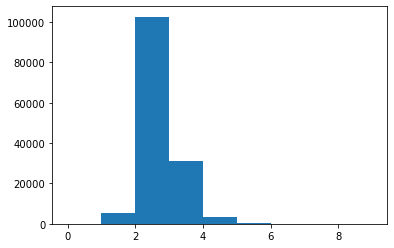

In [17]:
plt.hist(list(node_degrees.values()), bins=range(10))

Most have degree 2, some have 3 and very few have 1 and 4. Looks plausible.

### How many Uber nodes and ways can we match with historic OSM?

In [18]:
unodes = set(uedges_df["osm_start_node_id"]).union(uedges_df["osm_end_node_id"])
uways = set(uedges_df["osm_way_id"])
onodes= set(df_nodes_osm["osmid"])
oways=set(df_ways_osm["osmid"])

In [19]:
uo_nodes = unodes.intersection(onodes)

In [20]:
len(uo_nodes)/len(unodes), len(unodes)-len(uo_nodes), len(uo_nodes), len(unodes)

(0.9968593931424254, 449, 142517, 142966)

In [21]:
uo_ways = uways.intersection(oways)

In [22]:
len(uo_ways)/len(uways), len(uways)-len(uo_ways), len(uo_ways), len(uways)

(0.9939591384517984, 458, 75359, 75817)

### extract geometry for Uber road (create road_graph_nodes.parquet and road_graph_edges.parquet) for Uber road graph

In [23]:
ambiguous = []
projected_geometries = []
status = []
for x_start_node,y_start_node,x_end_node,y_end_node,geometry,osm_way_id,hw,refs,osm_start_node_id,osm_end_node_id in zip(uedges_df["x_start_node"],uedges_df["y_start_node"],uedges_df["x_end_node"],uedges_df["y_end_node"],uedges_df["geometry_old"], uedges_df["osm_way_id"], uedges_df["highway"],uedges_df["refs"], uedges_df["osm_start_node_id"], uedges_df["osm_end_node_id"]):
#     print(x_start_node,y_start_node,x_end_node,y_end_node)
#     print(osm_way_id)
#     print(hw)
    
    # 
    if geometry is None:

        if hw is None:
            assert osm_way_id in uways
            assert osm_way_id not in oways
            status.append("no highway")
        else:
            status.append("no geometry")
        projected_geometries.append(None)
        continue
    coords = list(geometry.coords)
#     print(list(geometry.coords))    
#     assert len(set(geometry.coords))==len(list(geometry.coords)), (osm_way_id,len(set(geometry.coords)),len(list(geometry.coords)))
    
#     start_node_index = [i for i, coord in enumerate(coords) if coord==(x_start_node,y_start_node)]
    start_node_index = [i for i, ref in enumerate(refs) if ref ==osm_start_node_id ]
    if len(start_node_index) != 1:
#         print(x_start_node,y_start_node,x_end_node,y_end_node)
#         print(osm_start_node_id)
#         print(osm_end_node_id)
#         print(osm_way_id)
#         print(refs)
#         raise
        ambiguous.append(osm_way_id)
        projected_geometries.append(None)
        status.append("start node ambiguous")
#         print(x_start_node,y_start_node,x_end_node,y_end_node,geometry,osm_way_id,hw)
        continue
    start_node_index=start_node_index[0]
#     print(start_node_index)
    
#     end_node_index = [i for i, coord in enumerate(coords) if coord==(x_end_node,y_end_node)]
    end_node_index = [i for i, ref in enumerate(refs) if ref ==osm_end_node_id]
    
    if len(end_node_index) != 1:
        ambiguous.append(osm_way_id)
        projected_geometries.append(None)
        status.append("end node ambiguous")
#         print(x_start_node,y_start_node,x_end_node,y_end_node,geometry,osm_way_id,hw)
        continue
    end_node_index=end_node_index[0]
#     print(end_node_index)
    assert (start_node_index < end_node_index) or  (start_node_index > end_node_index) , (start_node_index ,end_node_index)
#     geometry = LineString(coords[start_node_index:end_node_index+1])
#     print(coords)
#     print(coords[4:2])
# #     break
#     break

    if start_node_index < end_node_index:
        projected_geometries.append(LineString(coords[start_node_index:end_node_index+1]))
    elif start_node_index > end_node_index:
        projected_geometries.append(LineString(reversed(coords[end_node_index:start_node_index+1])))
    else:
        raise
    status.append("ok")
    if len(projected_geometries[-1].coords)==0:
        print(start_node_index,end_node_index)
        print((x_start_node,y_start_node,x_end_node,y_end_node,geometry,osm_way_id,hw,refs,osm_start_node_id,osm_end_node_id))
        raise
uedges_df["geometry"] = projected_geometries
uedges_df["status"]=status        

In [24]:
# TODO visual inspection!
# TODO can improve on the ambiguous?
matching_stats_df = uedges_df.groupby(["highway","status"]).agg(count=("osmid","count"), avg_length_meters=("length_meters", "mean"))
matching_stats_df["percentage"] = matching_stats_df["count"]/len(uedges_df)*100
matching_stats_df = matching_stats_df.reset_index()
matching_stats_df

,highway,status,count,avg_length_meters,percentage
0,construction,end node ambiguous,1,48.515741,0.000413
1,construction,ok,1,14.792168,0.000413
2,construction,start node ambiguous,2,32.331285,0.000825
3,cycleway,end node ambiguous,5,25.873892,0.002063
4,cycleway,ok,1,31.026128,0.000413
5,cycleway,start node ambiguous,8,64.030795,0.003301
6,living_street,ok,58,68.224552,0.023935
7,motorway,end node ambiguous,7,730.112952,0.002889
8,motorway,ok,1520,691.094745,0.627259
9,motorway,start node ambiguous,2,NaN,0.000825


In [25]:
len(~uedges_df["geometry"].isnull())

242324

In [26]:
uedges_df[uedges_df["geometry"].isnull()].groupby("highway").agg(count=("osmid","count"), avg_length_meters=("length_meters", "mean"), med_length_meters=("length_meters", "median"), status=("status", set))

,count,avg_length_meters,med_length_meters,status
highway,,,,
construction,3,37.726104,34.568534,"{start node ambiguous, end node ambiguous}"
cycleway,13,49.355063,39.735825,"{end node ambiguous, start node ambiguous}"
motorway,9,730.112952,681.998125,"{start node ambiguous, end node ambiguous}"
motorway_link,10,196.061194,196.061194,"{end node ambiguous, start node ambiguous}"
primary,2446,80.689172,50.019751,"{end node ambiguous, start node ambiguous}"
primary_link,37,49.504642,46.446726,"{end node ambiguous, start node ambiguous}"
proposed,15,97.109814,46.960805,"{end node ambiguous, start node ambiguous}"
residential,1124,94.353521,66.526227,"{end node ambiguous, start node ambiguous}"
secondary,980,94.238521,52.541135,"{end node ambiguous, start node ambiguous}"


In [27]:
uedges_df[(uedges_df["geometry"].isnull())&(uedges_df["highway"]=="motorway")]

# refs [311070, 3744469281] 
# https://www.openstreetmap.org/way/345803322#map=17/51.25284/-0.12408
# https://www.openstreetmap.org/node/202995#map=16/51.2518/-0.1270       -> probably just deleted between recording and OSM version
# https://www.openstreetmap.org/node/3744469281#map=19/51.25548/-0.12439 -> in OSM
# here we could fix if the missing one has just one outgoing edge.


,osmid,version,timestamp,changeset,highway,maxspeed,name,refs,full_geometry,valid_geometry,geometry,osm_start_node_id,osm_end_node_id,osm_way_id,osmid_start_node,y_start_node,x_start_node,version_start_node,timestamp_start_node,changeset_start_node,geometry_start_node,osmid_end_node,y_end_node,x_end_node,version_end_node,timestamp_end_node,changeset_end_node,geometry_end_node,length_meters,geometry_old,status
10845,345803322,5,2019-09-07T17:47:24Z,0,motorway,70 mph,,"[311070, 3744469281]",True,True,None,311070,202995,345803322,3.110700e+05,51.256757,-0.125060,5,2015-09-15T18:19:19Z,0,POINT (-0.12506 51.25676),NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,"LINESTRING (-0.12506 51.25676, -0.12539 51.25745)",end node ambiguous
10860,83824115,13,2019-09-07T17:55:14Z,0,motorway,50 mph,,"[315851, 6779643488, 315860]",True,True,None,315860,244418471,83824115,3.158600e+05,51.159548,-0.135455,5,2012-07-27T21:55:46Z,0,POINT (-0.13545 51.15955),2.444185e+08,51.159520,-0.134936,5,2011-11-10T17:39:10Z,0,POINT (-0.13494 51.15952),57.753394,"LINESTRING (-0.13576 51.15944, -0.13563 51.159...",end node ambiguous
140776,146246452,14,2019-09-24T14:49:36Z,0,motorway,70 mph,,"[471548932, 1595262231, 1595262245, 1595262253...",True,True,None,471548932,4179451710,146246452,4.715489e+08,51.397149,-0.552579,1,2009-08-20T17:17:30Z,0,POINT (-0.55258 51.39715),4.179452e+09,51.398907,-0.547851,2,2019-04-30T14:38:51Z,0,POINT (-0.54785 51.39891),560.963936,"LINESTRING (-0.55258 51.39715, -0.55158 51.397...",end node ambiguous
169336,24150832,19,2019-09-24T10:48:42Z,0,motorway,70 mph,,"[1517554590, 6819604163, 1596347434, 6819604165]",True,True,None,1517554590,1596347432,24150832,1.517555e+09,51.400988,-0.529518,8,2019-09-24T10:48:42Z,0,POINT (-0.52952 51.40099),1.596347e+09,51.400744,-0.536736,4,2019-09-24T10:48:42Z,0,POINT (-0.53674 51.40074),803.032315,"LINESTRING (-0.52952 51.40099, -0.53079 51.401...",end node ambiguous
172064,420113758,5,2019-09-19T14:28:25Z,0,motorway,70 mph,,"[6020112168, 6771651441, 1595125693]",True,True,None,1595125713,1595125693,420113758,NaN,NaN,NaN,NaN,NaN,NaN,None,1.595126e+09,51.351637,-0.690761,3,2018-10-28T18:25:45Z,0,POINT (-0.69076 51.35164),NaN,"LINESTRING (-0.68644 51.35328, -0.68908 51.352...",start node ambiguous
172070,43621346,19,2019-09-04T10:59:43Z,0,motorway,70 mph,,"[1595171635, 1595171627, 1595171611, 159517160...",True,True,None,1595171635,1595125713,43621346,1.595172e+09,51.357771,-0.675192,2,2019-09-24T12:52:16Z,0,POINT (-0.67519 51.35777),NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,"LINESTRING (-0.67519 51.35777, -0.67610 51.357...",end node ambiguous
172155,154719666,16,2019-09-24T16:19:43Z,0,motorway,70 mph,,"[1596347432, 1596347414, 1596347408, 159634739...",True,True,None,1596347432,148798332,154719666,1.596347e+09,51.400744,-0.536736,4,2019-09-24T10:48:42Z,0,POINT (-0.53674 51.40074),1.487983e+08,51.398037,-0.549940,5,2019-09-24T16:19:43Z,0,POINT (-0.54994 51.39804),1498.702163,"LINESTRING (-0.53674 51.40074, -0.53781 51.400...",end node ambiguous
213979,370758055,4,2019-09-07T17:47:24Z,0,motorway,70 mph,,"[3744469281, 3744469283, 170602610, 1404599360...",True,True,None,3744469280,203043,370758055,NaN,NaN,NaN,NaN,NaN,NaN,None,2.030430e+05,51.262949,-0.127587,3,2011-08-19T14:37:11Z,0,POINT (-0.12759 51.26295),NaN,"LINESTRING (-0.12539 51.25745, -0.12583 51.258...",start node ambiguous
217932,420113757,5,2019-09-19T16:06:11Z,0,motorway,70 mph,,"[4200910543, 6020113693]",True,True,None,4200910543,1595125747,420113757,4.200911e+09,51.352398,-0.689514,3,2019-09-19T16:06:11Z,0,POINT (-0.68951 51.35240),NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,"LINESTRING (-0.68951 51.35240, -0.68583 51.35380)",end node ambiguous


In [28]:
uedges_debug_gdf = gpd.GeoDataFrame.from_records([{"name":name, "geometry": LineString(geometry.coords)} for name,geometry,status in zip(uedges_df["name"],uedges_df["geometry_old"],uedges_df["status"]) if geometry is not None and "ambiguous" in status])
uedges_debug_gdf

,name,geometry
0,New End,"LINESTRING (-0.17633 51.55816, -0.17622 51.55863)"
1,Haverstock Hill,"LINESTRING (-0.15309 51.54404, -0.15322 51.544..."
2,Hyde Park Place Bayswater Road,"LINESTRING (-0.16517 51.51271, -0.16470 51.512..."
3,Marble Arch,"LINESTRING (-0.15963 51.51327, -0.15929 51.513..."
4,Hyde Park Street,"LINESTRING (-0.16764 51.51246, -0.16776 51.512..."
...,...,...
7188,First Avenue,"LINESTRING (0.12893 51.77961, 0.12917 51.77962..."
7189,,"LINESTRING (0.12937 51.77958, 0.12894 51.77949..."
7190,,"LINESTRING (-0.33919 51.61085, -0.33919 51.610..."
7191,,"LINESTRING (-0.33967 51.61087, -0.33964 51.610..."


In [29]:
uedges_debug_gdf.to_parquet(f"{CITY}_road_graph_edges_debug.parquet")

In [30]:
uedges_debug_gdf.to_file(f"{CITY}_road_graph_edges_debug.gpkg", driver="GPKG", layer="edges")

## Add speed_kph

In [31]:
edges = uedges_df

# Logic taken from
# https://github.com/gboeing/osmnx/blob/ad54852a3131800b1eedeb167eccaa0276abd998/osmnx/speed.py

from osmnx.speed import _collapse_multiple_maxspeed_values, _clean_maxspeed


hwy_speeds=None
fallback=np.nan
precision=1
agg=np.mean

# collapse any highway lists (can happen during graph simplification)
# into string values simply by keeping just the first element of the list
edges["highway"] = edges["highway"].map(lambda x: x[0] if isinstance(x, list) else x)

if "maxspeed" in edges.columns:
    # collapse any maxspeed lists (can happen during graph simplification)
    # into a single value
    edges["maxspeed"] = edges["maxspeed"].apply(_collapse_multiple_maxspeed_values, agg=agg)

    # create speed_kph by cleaning maxspeed strings and converting mph to
    # kph if necessary
    edges["speed_kph"] = edges["maxspeed"].astype(str).map(_clean_maxspeed).astype(float)
else:
    # if no edges in graph had a maxspeed attribute
    edges["speed_kph"] = None

# if user provided hwy_speeds, use them as default values, otherwise
# initialize an empty series to populate with values
if hwy_speeds is None:
    hwy_speed_avg = pd.Series(dtype=float)
else:
    hwy_speed_avg = pd.Series(hwy_speeds).dropna()

# for each highway type that caller did not provide in hwy_speeds, impute
# speed of type by taking the mean of the preexisting speed values of that
# highway type
for hwy, group in edges.groupby("highway"):
    if hwy not in hwy_speed_avg:
        hwy_speed_avg.loc[hwy] = agg(group["speed_kph"])

# if any highway types had no preexisting speed values, impute their speed
# with fallback value provided by caller. if fallback=np.nan, impute speed
# as the mean speed of all highway types that did have preexisting values
hwy_speed_avg = hwy_speed_avg.fillna(fallback).fillna(agg(hwy_speed_avg))

# for each edge missing speed data, assign it the imputed value for its
# highway type
speed_kph = (
    edges[["highway", "speed_kph"]].set_index("highway").iloc[:, 0].fillna(hwy_speed_avg)
)

# all speeds will be null if edges had no preexisting maxspeed data and
# caller did not pass in hwy_speeds or fallback arguments
if pd.isnull(speed_kph).all():
    raise ValueError(
        (
            "this graph's edges have no preexisting `maxspeed` "
            "attribute values so you must pass `hwy_speeds` or "
            "`fallback` arguments."
        )
    )

# add speed kph attribute to graph edges
edges["speed_kph"] = speed_kph.round(precision).values

## Output road_graph_nodes.parquet and road_graph_edges.parquet in compliant format

In [32]:
# edges_attributes_list = ["u", "v", "osmid", "speed_kph", "maxspeed", "highway", "oneway", "lanes", "tunnel", "length_meters", "geometry"]
# [["node_id", "x", "y"]]

In [33]:
for u,v,osmid,highway,length_meters,geometry,status in zip(
        uedges_df["osm_start_node_id"],
        uedges_df["osm_end_node_id"],
        uedges_df["osm_way_id"],
        uedges_df["highway"],
        uedges_df["length_meters"],
        uedges_df["geometry"],
        uedges_df["status"]
    ):
    if status=="ok" and len(geometry.coords)==0:
        print((u,v,osmid,highway,length_meters,geometry,status))
        break

In [34]:
uedges_gdf = gpd.GeoDataFrame.from_records([{
    "gkey": f"{u}_{v}_{osmid}", # TODO hacky
    "u":u, 
    "v":v, 
    "osmid":osmid, 
    "speed_kph": speed_kph, 
    "maxspeed": maxspeed, 
    "highway":highway, 
    "oneway":"", # TODO
    "lanes":"", # TODO
    "tunnel":"", # TODO
    "length_meters":length_meters, 
    "geometry": LineString(geometry.coords),
    "name": name # TODO in addition to data_pipeline - add there as well?
} 
    for u,v,osmid,speed_kph,maxspeed,highway,length_meters,geometry,status,name in zip(
        uedges_df["osm_start_node_id"],
        uedges_df["osm_end_node_id"],
        uedges_df["osm_way_id"],
        uedges_df["speed_kph"],
        uedges_df["maxspeed"],
        uedges_df["highway"],
        uedges_df["length_meters"],
        uedges_df["geometry"],
        uedges_df["status"],
        uedges_df["name"],
    ) if status=="ok"])
uedges_gdf

,gkey,u,v,osmid,speed_kph,maxspeed,highway,oneway,lanes,tunnel,length_meters,geometry,name
0,78112_25508583_129375498,78112,25508583,129375498,40.4,,unclassified,,,,19.407060,"LINESTRING (-0.14579 51.52698, -0.14578 51.52680)",Outer Circle
1,78112_25508584_129375498,78112,25508584,129375498,40.4,,unclassified,,,,63.857249,"LINESTRING (-0.14579 51.52698, -0.14581 51.52755)",Outer Circle
2,99936_2146383887_204647020,99936,2146383887,204647020,48.3,30 mph,unclassified,,,,12.645031,"LINESTRING (-0.15279 51.52361, -0.15268 51.52363)",York Gate
3,99936_4544836433_233623258,99936,4544836433,233623258,48.3,30 mph,unclassified,,,,47.220818,"LINESTRING (-0.15279 51.52361, -0.15294 51.523...",York Gate
4,99937_200047_4257261,99937,200047,4257261,48.3,30 mph,unclassified,,,,59.033945,"LINESTRING (-0.15202 51.52302, -0.15232 51.523...",York Gate
...,...,...,...,...,...,...,...,...,...,...,...,...,...
234303,6577730921_254761207_358627524,6577730921,254761207,358627524,46.2,,tertiary,,,,134.082828,"LINESTRING (-0.20947 51.52118, -0.20849 51.52188)",Golborne Road
234304,6577730921_6577730928_8227762,6577730921,6577730928,8227762,36.3,,residential,,,,51.325126,"LINESTRING (-0.20947 51.52118, -0.20935 51.521...",Bevington Road
234305,6577730928_2379175_700435511,6577730928,2379175,700435511,36.3,,residential,,,,57.576832,"LINESTRING (-0.20901 51.52114, -0.20906 51.521...",Bevington Road
234306,6577745911_36728211_646234311,6577745911,36728211,646234311,48.3,30 mph,primary,,,,305.243521,"LINESTRING (-0.23975 51.41129, -0.23904 51.411...",Coombe Lane


In [35]:
uedges_gdf[uedges_gdf["osmid"]=="129375498"]

,gkey,u,v,osmid,speed_kph,maxspeed,highway,oneway,lanes,tunnel,length_meters,geometry,name
0,78112_25508583_129375498,78112,25508583,129375498,40.4,,unclassified,,,,19.407060,"LINESTRING (-0.14579 51.52698, -0.14578 51.52680)",Outer Circle
1,78112_25508584_129375498,78112,25508584,129375498,40.4,,unclassified,,,,63.857249,"LINESTRING (-0.14579 51.52698, -0.14581 51.52755)",Outer Circle
227,103928_25508583_129375498,103928,25508583,129375498,40.4,,unclassified,,,,77.305720,"LINESTRING (-0.14576 51.52611, -0.14578 51.52680)",Outer Circle
228,103928_6307210478_129375498,103928,6307210478,129375498,40.4,,unclassified,,,,13.666990,"LINESTRING (-0.14576 51.52611, -0.14576 51.52598)",Outer Circle
42141,25508583_78112_129375498,25508583,78112,129375498,40.4,,unclassified,,,,19.407060,"LINESTRING (-0.14578 51.52680, -0.14579 51.52698)",Outer Circle
42142,25508583_103928_129375498,25508583,103928,129375498,40.4,,unclassified,,,,77.305720,"LINESTRING (-0.14578 51.52680, -0.14576 51.52611)",Outer Circle
42143,25508584_78112_129375498,25508584,78112,129375498,40.4,,unclassified,,,,63.857249,"LINESTRING (-0.14581 51.52755, -0.14579 51.52698)",Outer Circle
42144,25508584_1427449243_129375498,25508584,1427449243,129375498,40.4,,unclassified,,,,7.084361,"LINESTRING (-0.14581 51.52755, -0.14581 51.52761)",Outer Circle
161375,1427421985_6307210478_129375498,1427421985,6307210478,129375498,40.4,,unclassified,,,,80.160277,"LINESTRING (-0.14576 51.52526, -0.14577 51.525...",Outer Circle
161376,1427449243_25508584_129375498,1427449243,25508584,129375498,40.4,,unclassified,,,,7.084361,"LINESTRING (-0.14581 51.52761, -0.14581 51.52755)",Outer Circle


In [36]:
uedges_gdf.dtypes

gkey               object
u                   int64
v                   int64
osmid              object
speed_kph         float64
maxspeed           object
highway            object
oneway             object
lanes              object
tunnel             object
length_meters     float64
geometry         geometry
name               object
dtype: object

In [37]:
assert type(uedges_gdf) == gpd.geodataframe.GeoDataFrame

In [38]:
# TODO naming as "london/road_graph_edges.parquet"
uedges_gdf.to_parquet(f"{CITY}_road_graph_edges.parquet")

In [39]:
uedges_gdf.to_file(f"{CITY}_road_graph_edges.gpkg", driver="GPKG", layer="edges")

In [40]:
nodes_in_uedges_gdf = set(uedges_gdf["u"]).union(uedges_gdf["v"])
nodes_in_uedges_gdf

{26214413,
 18874385,
 14680082,
 18874386,
 18874387,
 26214418,
 14680087,
 18874392,
 14680091,
 14680092,
 14680093,
 14680094,
 14680095,
 18874399,
 18874400,
 242745372,
 242745375,
 18874405,
 287309864,
 1656225842,
 1674575933,
 18874433,
 145752130,
 18874435,
 18874439,
 18874440,
 1399324743,
 18874443,
 18874444,
 316145746,
 1399324755,
 18874458,
 57147489,
 1656225893,
 1399324775,
 1399324776,
 18874474,
 18874477,
 1656225903,
 1656225907,
 1399324795,
 26214525,
 558891134,
 26214534,
 18874503,
 210763914,
 1656225932,
 251658391,
 535298200,
 1399324824,
 3670175,
 6018302112,
 535298209,
 6018302115,
 33030308,
 6018302118,
 33030323,
 1656225973,
 1399324861,
 535298238,
 2118647999,
 1687683264,
 2268594377,
 1399324890,
 1037041895,
 5316280552,
 1037041904,
 57147641,
 5783421177,
 1399324934,
 173015312,
 251658519,
 145752345,
 689963292,
 1399324958,
 70779168,
 1687683363,
 2269643049,
 2269643053,
 2269643056,
 2269643060,
 2269643067,
 2269643068,
 4840

In [41]:
unodes_gdf = gpd.GeoDataFrame.from_records([{
    "node_id":node_id, 
    "x":x, 
    "y":y,
    "geometry": geometry} 
    for node_id,x,y,geometry in zip(
        df_nodes_osm["osmid"],
        df_nodes_osm["x"],
        df_nodes_osm["y"],
        df_nodes_osm["geometry"]
    )
    if node_id in nodes_in_uedges_gdf
])
unodes_gdf

,node_id,x,y,geometry
0,78112,-0.145792,51.526976,POINT (-0.14579 51.52698)
1,99936,-0.152791,51.523611,POINT (-0.15279 51.52361)
2,99937,-0.152024,51.523018,POINT (-0.15202 51.52302)
3,99940,-0.155763,51.523085,POINT (-0.15576 51.52308)
4,101818,-0.148104,51.535179,POINT (-0.14810 51.53518)
...,...,...,...,...
140407,6577710674,-0.225660,51.505155,POINT (-0.22566 51.50515)
140408,6577710675,-0.227720,51.502322,POINT (-0.22772 51.50232)
140409,6577730921,-0.209469,51.521176,POINT (-0.20947 51.52118)
140410,6577730928,-0.209009,51.521139,POINT (-0.20901 51.52114)


In [42]:
unodes_gdf.to_parquet(f"{CITY}_road_graph_nodes.parquet")

In [43]:
unodes_gdf.to_file(f"{CITY}_road_graph_nodes.gpkg", driver="GPKG", layer="nodes")

In [44]:
unodes_gdf[unodes_gdf["node_id"]==2348324108]

,node_id,x,y,geometry
114938,2348324108,-0.720106,51.996974,POINT (-0.72011 51.99697)


In [45]:
uedges_gdf[uedges_gdf["u"]==2348324108]

,gkey,u,v,osmid,speed_kph,maxspeed,highway,oneway,lanes,tunnel,length_meters,geometry,name
194707,2348324108_21585864_10441608,2348324108,21585864,10441608,36.3,,residential,,,,30.111907,"LINESTRING (-0.72011 51.99697, -0.71997 51.99721)",Victoria Road


In [46]:
assert len(uedges_gdf) == matching_stats_df[matching_stats_df["status"]=="ok"]["count"].sum()